# Making sense of data: introduction to statistics for gravitational-wave astronomy

### *AEI IMPRS Lecture Course*
### Jonathan Gair *jgair@aei.mpg.de*
Material originally produced by Stephen Green *stephen.green2@nottingham.ac.uk*

---

## Practical session on machine learning for gravitational waves

In this tutorial we will build a simple **parameter estimation** neural network:
* **Training data:** TaylorF2 waveforms, high SNR, parametrized only by masses; noise added during training
* **Posterior model:** Gaussian with learnable (diagonal) covariance matrix

This should run in about a minute on a laptop.

### Exercises
1. Add new parameters, beyond the masses
2. Extend the Gaussian distribution to include general covariance
3. Make a PP plot

## Imports

In [3]:
from pycbc.waveform import get_fd_waveform, fd_approximants
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import FrequencySeries
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import corner

In [4]:
# pytorch imports
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.utils.data import DataLoader

## Training data

Generate a training set that (for simplicity) samples only over the component masses. Generate frequency-domain waveforms using TaylorF2. We will add noise during training.

**Exercise:** Add more parameters

In [5]:
num_samples = 10000  # size of the training set

m_lower = 20.0  # solar masses
m_upper = 80.0
masses = m_lower + np.random.random((num_samples, 2)) * (m_upper - m_lower)

# Make sure m1 > m2
masses = np.sort(masses, axis=-1)
masses = np.flip(masses, axis=-1)

In [6]:
masses

array([[65.07163738, 57.06456219],
       [77.02719147, 38.1495119 ],
       [68.8129524 , 44.73788987],
       ...,
       [72.32874327, 34.24114428],
       [78.3283205 , 30.13357703],
       [54.06133375, 24.66705193]])

In [7]:
# Fixed parameters

distance = 1000  # Mpc
inclination = 0.0  # face on
spin1x = 0.0
spin1y = 0.0
spin1z = 0.0
spin2x = 0.0
spin2y = 0.0
spin2z = 0.0
phase = 0.0

In [8]:
# Waveform settings

approximant = 'TaylorF2'
f_lower = 20.0
f_final = 1024.0
T = 1.0

delta_f = 1 / T
nf = int(f_final / delta_f) + 1
f_array = np.linspace(0.0, f_final, num=nf)

In [9]:
# Noise PSD

psd = np.array(aLIGOZeroDetHighPower(nf, delta_f, 0.0))
psd[0] = psd[1]  # Fix up endpoints
psd[-1] = psd[-2]

asd = np.sqrt(psd)

In [10]:
# Generate training waveforms

hp_list = []
hc_list = []

for i in range(num_samples):
    
    mass1, mass2 = masses[i]
    
    hp, hc = get_fd_waveform(approximant=approximant,
                             mass1=mass1, mass2=mass2,
                             inclination=inclination,
                             distance=distance,
                             coa_phase = phase,
                             spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,
                             spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,        
                             delta_f=delta_f,
                             f_lower=f_lower, f_final=f_final)
    
    f_array = np.array(hp.sample_frequencies)
    
    # Whiten waveforms and rescale so that white noise has unit variance
    hp = hp / asd * np.sqrt(4.0 * delta_f)
    hc = hc / asd * np.sqrt(4.0 * delta_f)
    
    hp_list.append(hp)
    hc_list.append(hc)

hp = np.array(hp_list)
hc = np.array(hc_list)

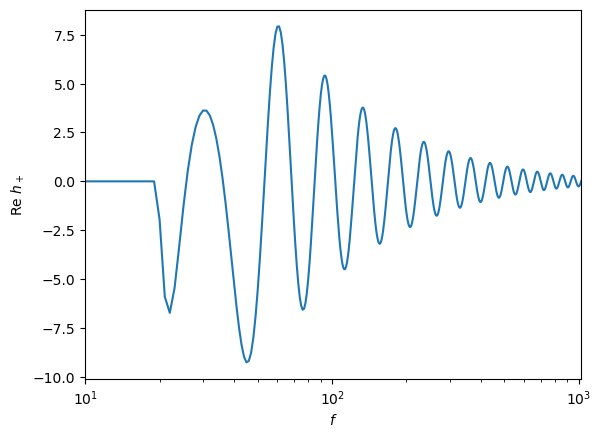

In [11]:
# Sample waveform

plt.plot(f_array, hp[0].real)
plt.xscale('log')
plt.xlabel('$f$')
plt.ylabel('Re $h_+$')
plt.xlim((10, f_final))
plt.show()

### Package into a pytorch Dataset

In [12]:
# Parameters
#
# This is just the masses. It's better to sample in (Mc, q) rather than (m1, m2) because the posterior is more Gaussian

m1 = masses[:, 0]
m2 = masses[:, 1]

Mc = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)
q = m2 / m1

parameters = np.stack((Mc, q), axis=1).astype(np.float32)

In [13]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set)

parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std

In [14]:
# Waveforms
#
# Truncate the arrays to remove zeros below f_lower, and repackage real and imaginary parts
#
# Only consider h_plus for now

lower_cut = int(f_lower / delta_f)
waveforms = np.hstack((hp.real[:, lower_cut:], hp.imag[:, lower_cut:])).astype(np.float32)

In [15]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = np.random.normal(size = signal.shape).astype(np.float32)
        data = signal + noise
        
        return torch.tensor(data), torch.tensor(params)

In [16]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

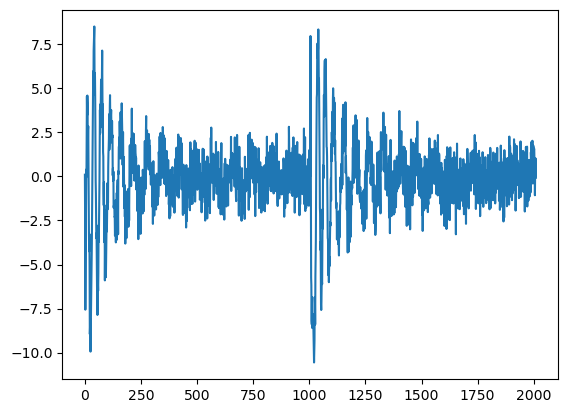

In [17]:
# We can sample from the WaveformDataset. This gives us pairs of data and parameters, different noise realizations each time.

x, y = waveform_dataset[0]
plt.plot(x)

## Posterior Model

In [18]:
# Neural networks are constructed by subclassing nn.Module
#
# This has to implement an __init__() and forward() method

class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        
        # Hidden layers
        hidden_net_list = []
        hidden_net_list.append(
            nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.hidden_net_list = nn.ModuleList(hidden_net_list)
        
        # Output layers
        self.output_mean = nn.Linear(hidden_dims[-1], output_dim)
        self.output_log_sigma = nn.Linear(hidden_dims[-1], output_dim)
        
        # Activation function
        self.activation = activation
        
    def forward(self, x):
        """Pass x through all the layers of the network and return the Gaussian distribution"""
        
        h = x
        for layer in self.hidden_net_list:
            h = self.activation(layer(h))

        # Output layer defines a Gaussian
        mean = self.output_mean(h)
        log_sigma = self.output_log_sigma(h)
        sigma = torch.exp(log_sigma)
        
        # Create the Gaussian distribution
        dist = torch.distributions.MultivariateNormal(loc=mean, scale_tril=torch.diag_embed(sigma))
        
        return dist

In [19]:
input_dim = waveforms.shape[-1]
output_dim = parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

model = NeuralNetwork(input_dim, hidden_dims, output_dim)

In [20]:
print(model)

NeuralNetwork(
  (hidden_net_list): ModuleList(
    (0): Linear(in_features=2010, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_mean): Linear(in_features=32, out_features=2, bias=True)
  (output_log_sigma): Linear(in_features=32, out_features=2, bias=True)
  (activation): ReLU()
)


## Training

In [21]:
# Split the dataset into training and test sets

train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [22]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data

train_features, train_labels = next(iter(train_dataloader))

In [23]:
train_features

tensor([[-3.0738e+00, -1.8799e+00,  3.2877e+00,  ..., -9.2901e-01,
         -1.1332e-01, -5.0665e-01],
        [ 8.7316e-01, -3.5374e+00, -5.0993e+00,  ..., -2.2817e-01,
          1.1675e+00,  1.3854e+00],
        [-4.3710e+00,  3.9426e-01,  3.6573e+00,  ..., -5.5913e-01,
          4.9645e-03, -1.2701e+00],
        ...,
        [ 4.1156e+00, -2.0737e+00,  6.7827e-01,  ..., -2.0176e+00,
          2.1907e-01,  6.8691e-01],
        [-9.2618e-01, -4.3886e-01,  2.9535e+00,  ..., -3.1478e-02,
          1.0478e+00, -6.2176e-01],
        [-7.0496e-01, -4.4579e+00, -5.1304e+00,  ...,  1.0820e+00,
         -6.2158e-01, -7.4110e-01]])

In [24]:
train_features.shape

torch.Size([64, 2010])

In [25]:
# We use the Adam optimizer.

optimizer = torch.optim.Adam(model.parameters())

In [26]:
# Training and test loops

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss
        dist = model(X)        
        loss = - dist.log_prob(y)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
        
        
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            dist = model(X)
            loss = - dist.log_prob(y)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [27]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 2.811365  [    0/ 8000 samples]
Loss: 0.351078  [ 3200/ 8000 samples]
Loss: 0.292879  [ 6400/ 8000 samples]
Average loss: 0.6702
Test loss: 1.009246 

Epoch 2
-------------------------------
Loss: 1.128868  [    0/ 8000 samples]
Loss: -0.334791  [ 3200/ 8000 samples]
Loss: -0.040618  [ 6400/ 8000 samples]
Average loss: -0.5340
Test loss: -1.099209 

Epoch 3
-------------------------------
Loss: -1.175656  [    0/ 8000 samples]
Loss: -1.583228  [ 3200/ 8000 samples]
Loss: -1.040503  [ 6400/ 8000 samples]
Average loss: -1.2718
Test loss: -1.156481 

Epoch 4
-------------------------------
Loss: -1.128179  [    0/ 8000 samples]
Loss: -1.539362  [ 3200/ 8000 samples]
Loss: -1.116925  [ 6400/ 8000 samples]
Average loss: -1.5585
Test loss: -1.545851 

Epoch 5
-------------------------------
Loss: -1.504123  [    0/ 8000 samples]
Loss: -2.230092  [ 3200/ 8000 samples]
Loss: -1.470516  [ 6400/ 8000 samples]
Average loss: -1.6342
Test loss: -1.78793

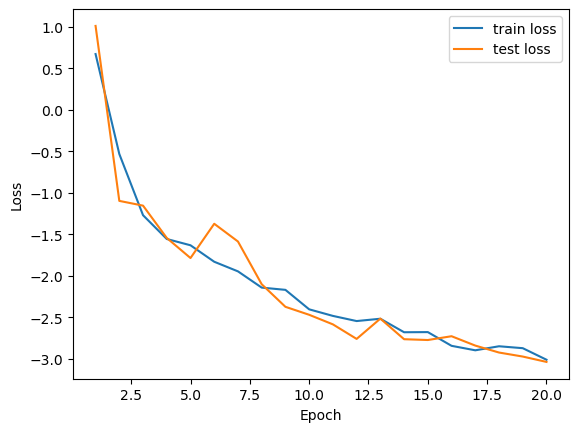

In [28]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

### Posterior plots

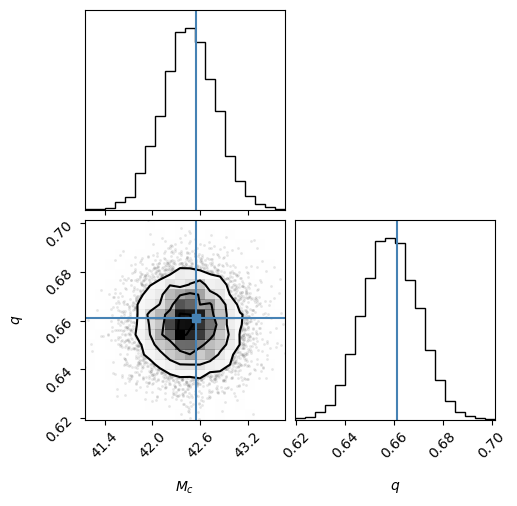

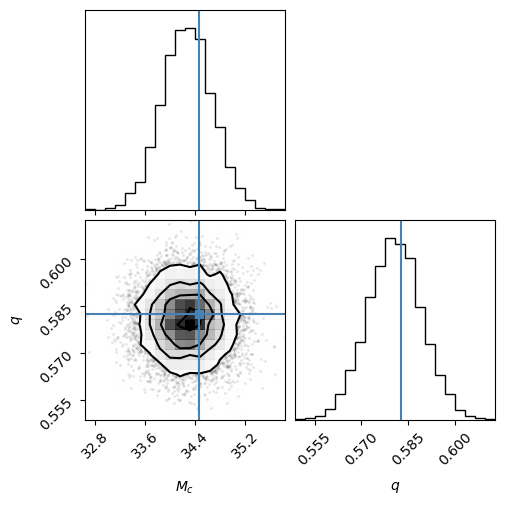

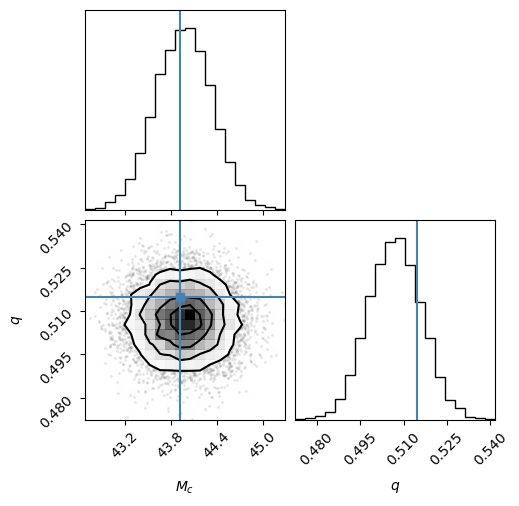

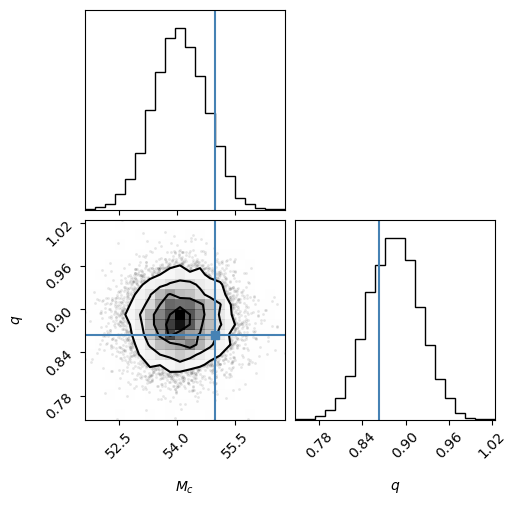

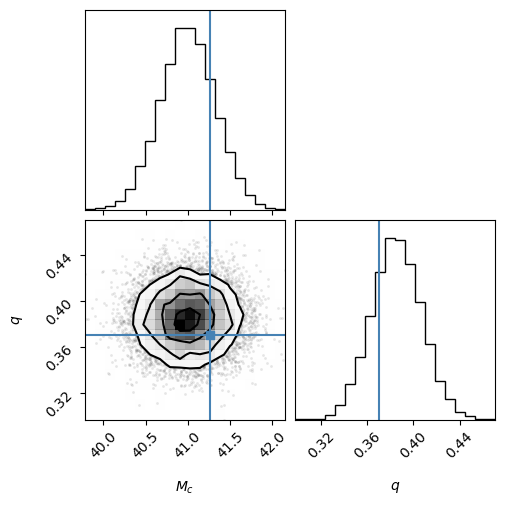

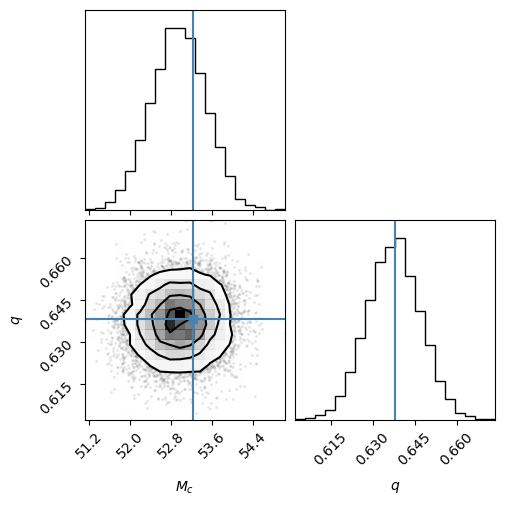

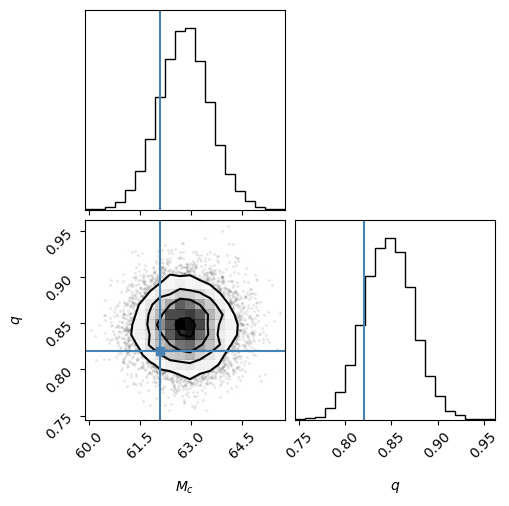

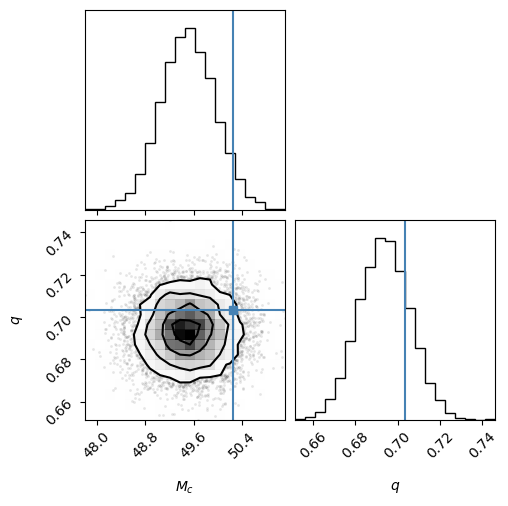

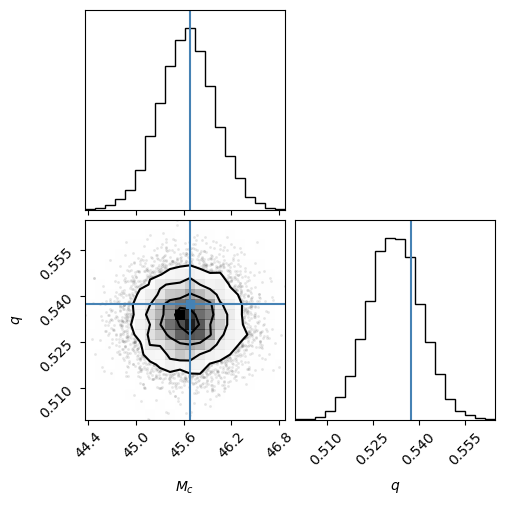

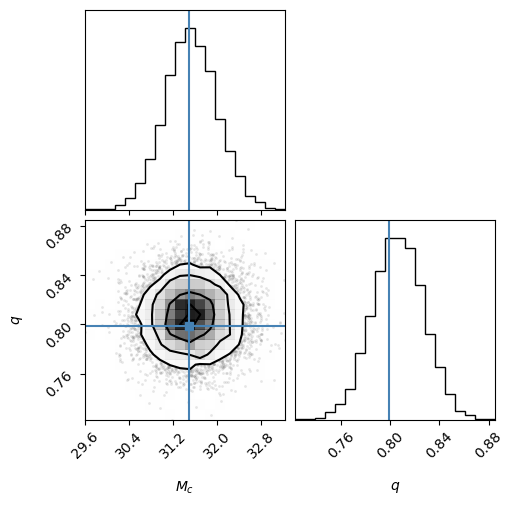

In [29]:
num_posteriors = 10
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Predict a posterior
    dist = model(test_x)

    # Sample the posterior
    pred_samples = dist.sample((10000,)).numpy()

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * test_y.numpy() + parameters_mean

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$M_c$', '$q$'])
    plt.show()